# ARS Full Experiment
## Replicating Mania et al. NeurIPS 2018
### *"Simple random search of static linear policies is competitive for reinforcement learning"*

**Paper protocol** (what this notebook tries to match):
- 5 ARS variants (BRS / V1 / V1-t / V2 / V2-t) on 6 MuJoCo locomotion tasks
- Phase 1: hyperparameter grid search, 3 seeds sampled from `[0, 1000)`, select by min episodes-to-threshold
- Phase 2: 100-seed evaluation with selected configs, Figure 1-style percentile plots
- Eval = 100 rollouts per checkpoint (paper §4)

**Known gaps vs. paper** (documented below):
1. **Distributed rollouts not implemented** — paper uses Ray workers + shared noise table; we run sequentially
2. **Two-phase protocol falls back to LQR/Pendulum** when `gymnasium[mujoco]` is not installed
3. **`QUICK_MODE=True`** reduces budget, grid size, and eval seeds for fast iteration
4. **MuJoCo budget is much shorter** than paper's 1M steps; results are directionally correct but not paper-faithful in magnitude

---
**Sections:**
1. Setup & environment detection
2. Sanity check
3. ARS variant comparison — Paper Table 1 equivalent
4. Hyperparameter sensitivity — σ, α, N (Paper Appendix A.3)
5. Two-phase evaluation protocol — Paper §5 + Figure 1
6. LQR dimension scaling — Paper Appendix A.1
7. MuJoCo locomotion — Paper Table 1 (all 6 tasks, requires mujoco)
8. Distributed implementation gap
9. Summary comparison

In [23]:
import os
import sys
import json
from pathlib import Path

# ── Navigate to repo root so `from src.*` imports work ──────────────────────
nb_dir = Path.cwd()
repo_root = nb_dir.parent if nb_dir.name == "notebooks" else nb_dir
os.chdir(repo_root)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams.update({
    "figure.dpi": 110,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 11,
})

# ── src imports ──────────────────────────────────────────────────────────────
from src.config import ExperimentConfig, EnvConfig, MethodConfig, SweepConfig
from src.runner import run_single, run_sweep
from src.analysis import (
    load_run, load_runs_from_dir, extract_eval_curve,
    compute_seed_stats, compute_percentile_stats,
    episodes_to_threshold, threshold_table, max_reward_table,
)
from src.run_sweep import (
    make_ars_variants, make_sigma_sensitivity,
    make_alpha_sensitivity, make_N_sensitivity,
    make_lqr_scaling, make_full_comparison,
)
from src.sweep_protocol import run_grid_phase, run_eval100_phase, TASK_THRESHOLDS

# ── Thresholds ───────────────────────────────────────────────────────────────
# Paper thresholds are defined only for the 6 MuJoCo tasks (Mania et al. Table 1).
# LQR/Pendulum thresholds are project-defined heuristics — NOT from the paper.
PAPER_THRESHOLDS = {
    "swimmer":     300.0,
    "hopper":     1900.0,
    "halfcheetah": 3000.0,
    "walker2d":   2500.0,
    "ant":        3000.0,
    "humanoid":   6000.0,
}
PROJECT_THRESHOLDS = {   # heuristic targets for non-paper tasks
    "lqr":      -50.0,
    "pendulum": -200.0,
}
ALL_THRESHOLDS = {**PAPER_THRESHOLDS, **PROJECT_THRESHOLDS}


def threshold_label(task: str) -> str:
    """Return an honest threshold label for plot annotations."""
    if task in PAPER_THRESHOLDS:
        return f"Paper threshold ({PAPER_THRESHOLDS[task]:.0f})"
    return f"Heuristic threshold ({PROJECT_THRESHOLDS.get(task, 0):.0f}, not from paper)"


# ── Experiment scale ─────────────────────────────────────────────────────────
# QUICK_MODE = True  → ~10–40 min CPU, no MuJoCo required
# QUICK_MODE = False → paper-scale (hours; MuJoCo recommended for Section 7)
QUICK_MODE = False

BUDGET            = 1600 if QUICK_MODE else 3200
SEEDS             = [0, 1, 2]
EVAL_EPISODES     = 100     # paper §4: always 100 rollouts per checkpoint
EVAL_SEEDS_COUNT  = 10  # if QUICK_MODE else 100   # for Phase 2 (paper: 100)
GRID_ALPHAS       = [0.01, 0.05]  if QUICK_MODE else [0.01, 0.02, 0.05]
GRID_N_VALUES     = [8, 16]       if QUICK_MODE else [8, 16, 32]
GRID_SIGMAS       = [0.01, 0.03]  if QUICK_MODE else [0.01, 0.03, 0.1]
RESULTS_DIR       = Path("results/notebook")

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Repo root  : {repo_root}")
print(f"Results dir: {RESULTS_DIR.resolve()}")
print(f"QUICK_MODE : {QUICK_MODE}")
print(f"  budget={BUDGET}, eval_episodes={EVAL_EPISODES}, eval_seeds={EVAL_SEEDS_COUNT}")

Repo root  : /Users/sungcho/project/stat4830
Results dir: /Users/sungcho/project/stat4830/results/notebook
QUICK_MODE : False
  budget=3200, eval_episodes=100, eval_seeds=10


In [26]:
# ── MuJoCo availability ───────────────────────────────────────────────────────
# Determines which tasks the two-phase protocol and Section 7 can use.
# The paper's actual evaluation is on the 6 MuJoCo locomotion tasks.
try:
    from src.envs.mujoco import MuJoCoEnv
    _e = MuJoCoEnv("swimmer")
    _e.close()
    MUJOCO_AVAILABLE = True
    print("✓ MuJoCo available")
except Exception as _exc:
    MUJOCO_AVAILABLE = False
    print(f"✗ MuJoCo not available: {_exc}")
    print("  To enable: pip install 'gymnasium[mujoco]' mujoco")

# ── Protocol tasks ────────────────────────────────────────────────────────────
# Paper §5: 6 MuJoCo tasks. We fall back to LQR+Pendulum if MuJoCo is unavailable.
if MUJOCO_AVAILABLE:
    # In quick mode limit to 2 tasks to keep grid-search runtime manageable.
    PROTOCOL_TASKS    = ["swimmer", "hopper"] if QUICK_MODE else [
        "swimmer", "hopper", "halfcheetah", "walker2d", "ant", "humanoid"
    ]
    PROTOCOL_VARIANTS = ["V2-t"]   # paper's best-performing variant
    PROTOCOL_NOTE     = "MuJoCo tasks (paper-faithful)"
    MJ_MAX_STEPS      = 1000
else:
    PROTOCOL_TASKS    = ["lqr", "pendulum"]
    PROTOCOL_VARIANTS = ["V2-t"]
    PROTOCOL_NOTE     = (
        "FALLBACK: LQR + Pendulum (MuJoCo not installed).\n"
        "These are NOT the paper's evaluation tasks.\n"
        "Install mujoco for paper-faithful results."
    )
    MJ_MAX_STEPS      = 200

print(f"\nProtocol tasks : {PROTOCOL_TASKS}")
print(f"Note           : {PROTOCOL_NOTE}")

✗ MuJoCo not available: Failed to create gymnasium env for task 'swimmer'. Ensure gymnasium[mujoco] and mujoco are installed: pip install gymnasium[mujoco] mujoco
  To enable: pip install 'gymnasium[mujoco]' mujoco

Protocol tasks : ['lqr', 'pendulum']
Note           : FALLBACK: LQR + Pendulum (MuJoCo not installed).
These are NOT the paper's evaluation tasks.
Install mujoco for paper-faithful results.


/Users/sungcho/project/stat4830/.venv/lib/python3.13/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment Swimmer-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


---
## Section 1 — Sanity Check

Single ARS V2-t run on 4D LQR to verify the implementation works before full sweeps.
Note: this uses `eval_episodes=20` (reduced from the paper's 100) for speed.

**Expected**: eval return climbs from ~−500 toward the heuristic threshold of −50.

Sanity check: ARS V2-t on 4D LQR, seed=0 ...
(eval_episodes=20 here for speed; paper uses 100)



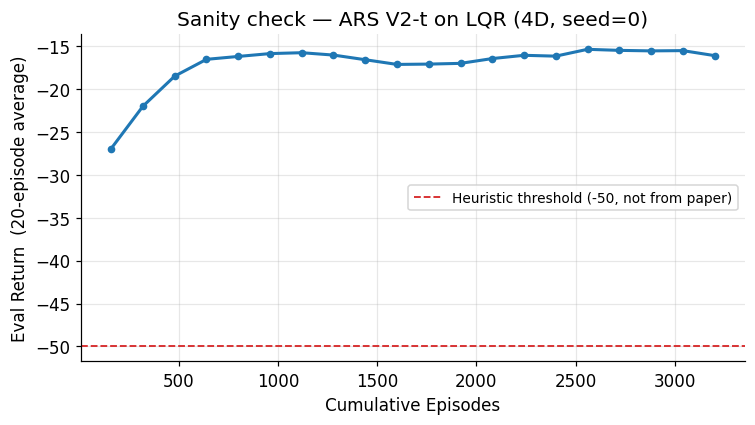

Final eval return: -16.1  (heuristic target ≥ -50)


In [2]:
print("Sanity check: ARS V2-t on 4D LQR, seed=0 ...")
print("(eval_episodes=20 here for speed; paper uses 100)\n")

_cfg = ExperimentConfig(
    env=EnvConfig(name="lqr", state_dim=4, action_dim=2),
    method=MethodConfig(
        name="ars", N=16, b=8, sigma=0.03, lr=0.02,
        reward_norm=True, use_state_norm=True, variant_label="V2-t",
    ),
    total_episode_budget=BUDGET,
    max_steps=200, eval_every_iters=5, eval_episodes=20,
    run_tag="sanity",
)
_path = run_single(_cfg, seed=0, results_dir=RESULTS_DIR / "sanity")
_run  = load_run(_path)
_eps, _rets = extract_eval_curve(_run)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(_eps, _rets, marker="o", ms=4, lw=2)
thr = PROJECT_THRESHOLDS["lqr"]
ax.axhline(thr, color="tab:red", ls="--", lw=1.2,
           label=threshold_label("lqr"))
ax.set_xlabel("Cumulative Episodes")
ax.set_ylabel("Eval Return  (20-episode average)")
ax.set_title("Sanity check — ARS V2-t on LQR (4D, seed=0)")
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

print(f"Final eval return: {_rets[-1]:.1f}  (heuristic target ≥ {thr:.0f})")

---
## Section 2 — ARS Variant Comparison
### *Paper Table 1 equivalent on LQR + Pendulum*

The paper evaluates 5 variants on all 6 MuJoCo tasks. We run on LQR and Pendulum
(the controlled envs always available in this codebase) to illustrate the same algorithmic
differences. Qualitative ordering should match — V2-t ≥ V2 ≥ V1-t ≥ V1 > BRS.

| Variant | Reward norm | State norm | b (directions) |
|---------|:-----------:|:----------:|:--------------:|
| BRS     | ✗           | ✗          | N (all)        |
| V1      | ✓           | ✗          | N (all)        |
| V1-t    | ✓           | ✗          | N//2 (top)     |
| V2      | ✓           | ✓          | N (all)        |
| V2-t    | ✓           | ✓          | N//2 (top)     |

Eval is 100 rollouts per checkpoint throughout (paper §4).

In [44]:
VARIANT_ORDER  = ["BRS", "V1", "V1-t", "V2", "V2-t"]
VARIANT_COLORS = {
    v: c for v, c in zip(VARIANT_ORDER, plt.cm.tab10(np.linspace(0, 0.9, 5)))
}

var_sweep = make_ars_variants(budget=BUDGET)
var_sweep.base.seeds = SEEDS
var_sweep.base.eval_episodes = EVAL_EPISODES   # paper: 100 rollouts
var_dir = RESULTS_DIR / "ars_variants"

n_total = len(var_sweep.variants) * len(SEEDS)
print(f"{len(var_sweep.variants)} variant configs × {len(SEEDS)} seeds = {n_total} runs")
print(f"  eval_episodes={EVAL_EPISODES} (paper standard)")
var_paths = run_sweep(var_sweep, var_dir)
print(f"\nDone. {len(var_paths)} result files.")

10 variant configs × 3 seeds = 30 runs
  eval_episodes=100 (paper standard)

Done. 30 result files.


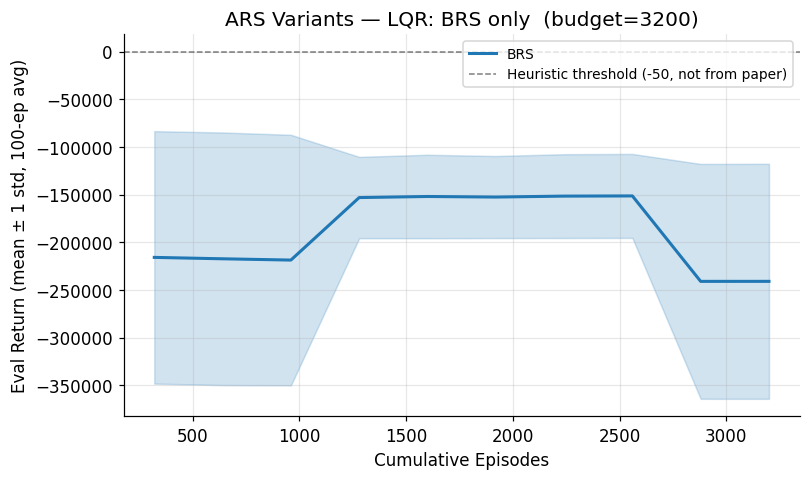

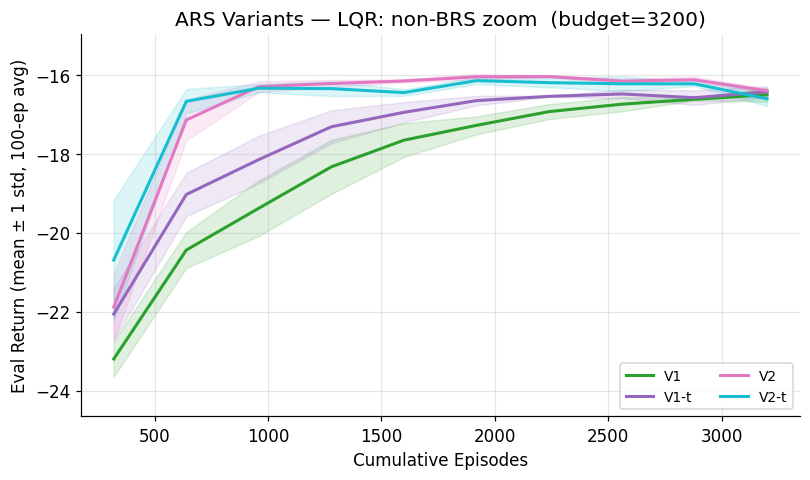

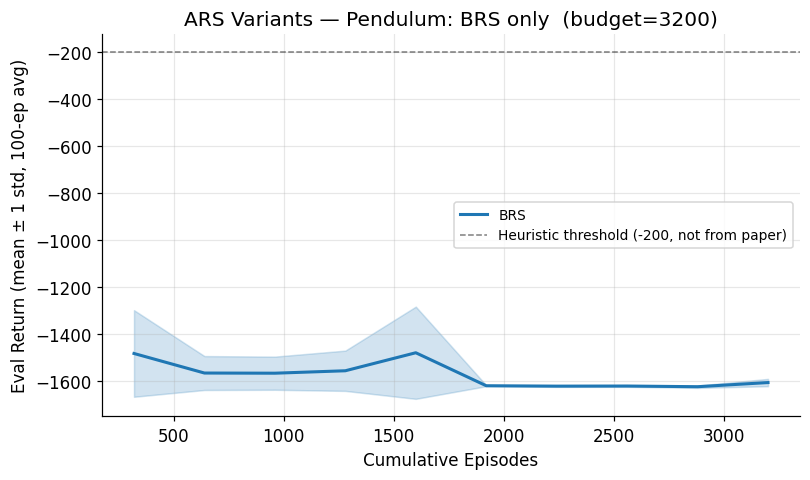

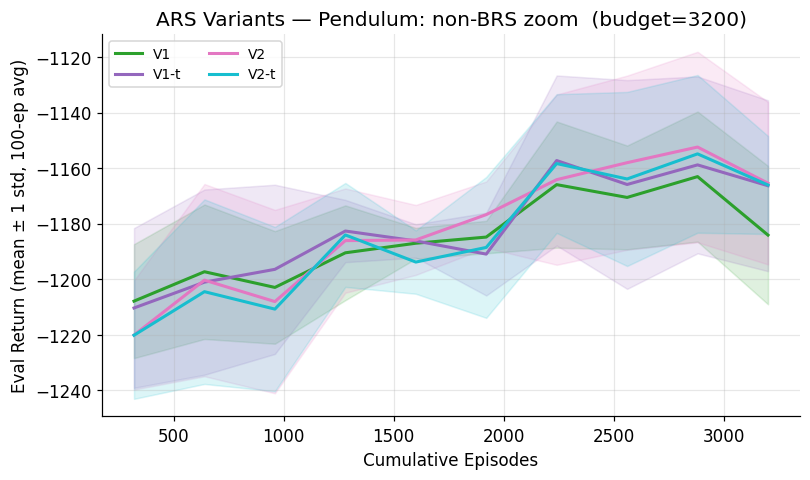

In [14]:
def group_runs(runs, key_fn):
    groups = {}
    for r in runs:
        k = key_fn(r)
        groups.setdefault(k, []).append(r)
    return groups


all_var_runs = load_runs_from_dir(var_dir)
var_groups = group_runs(
    all_var_runs,
    lambda r: (
        r["config"]["env"]["name"],
        r["config"]["method"].get("variant_label") or r["config"]["method"]["name"],
    ),
)

for env_name, env_label in [("lqr", "LQR"), ("pendulum", "Pendulum")]:
    # ---------------------- BRS only ----------------------
    key_brs = (env_name, "BRS")
    if key_brs in var_groups:
        stats = compute_seed_stats(var_groups[key_brs])
        eps  = stats["episodes"]
        mean = np.array(stats["mean"])
        std  = np.array(stats["std"])

        fig, ax = plt.subplots(figsize=(7.5, 4.5))
        ax.plot(eps, mean, label="BRS", color=VARIANT_COLORS["BRS"], lw=2)
        ax.fill_between(eps, mean - std, mean + std, alpha=0.2, color=VARIANT_COLORS["BRS"])

        thr = PROJECT_THRESHOLDS.get(env_name)
        if thr is not None:
            ax.axhline(thr, color="k", ls="--", lw=1, alpha=0.5,
                       label=threshold_label(env_name))

        ax.set_xlabel("Cumulative Episodes")
        ax.set_ylabel(f"Eval Return (mean ± 1 std, {EVAL_EPISODES}-ep avg)")
        ax.set_title(f"ARS Variants — {env_label}: BRS only  (budget={BUDGET})")
        ax.legend(fontsize=9)
        plt.tight_layout()
        plt.show()

    # ------------------- non-BRS only ---------------------
    non_brs = []
    for variant in ["V1", "V1-t", "V2", "V2-t"]:
        key = (env_name, variant)
        if key in var_groups:
            non_brs.append((variant, compute_seed_stats(var_groups[key])))

    if non_brs:
        fig, ax = plt.subplots(figsize=(7.5, 4.5))
        ymins, ymaxs = [], []

        for variant, stats in non_brs:
            eps  = stats["episodes"]
            mean = np.array(stats["mean"])
            std  = np.array(stats["std"])
            ax.plot(eps, mean, label=variant, color=VARIANT_COLORS[variant], lw=2)
            ax.fill_between(eps, mean - std, mean + std, alpha=0.15, color=VARIANT_COLORS[variant])
            ymins.append(np.min(mean - std))
            ymaxs.append(np.max(mean + std))

        # Tight y-axis based on non-BRS data only (improves separability)
        ylo = min(ymins)
        yhi = max(ymaxs)
        pad = max(0.05 * (yhi - ylo), 1.0)
        ax.set_ylim(ylo - pad, yhi + pad)

        thr = PROJECT_THRESHOLDS.get(env_name)
        if thr is not None and (ylo - pad) <= thr <= (yhi + pad):
            ax.axhline(thr, color="k", ls="--", lw=1, alpha=0.5,
                       label=threshold_label(env_name))

        ax.set_xlabel("Cumulative Episodes")
        ax.set_ylabel(f"Eval Return (mean ± 1 std, {EVAL_EPISODES}-ep avg)")
        ax.set_title(f"ARS Variants — {env_label}: non-BRS zoom  (budget={BUDGET})")
        ax.legend(ncol=2, fontsize=9)
        plt.tight_layout()
        plt.show()



In [15]:
# Table 1-style / Table 2-style summary for Section 2
for env_name, env_label in [("lqr", "LQR"), ("pendulum", "Pendulum")]:
    runs_by_variant = {
        v: var_groups[(env_name, v)]
        for v in VARIANT_ORDER
        if (env_name, v) in var_groups
    }
    if not runs_by_variant:
        continue

    thr = PROJECT_THRESHOLDS[env_name]
    print(f"\n{'═'*60}")
    print(f"  {env_label}  (heuristic threshold = {thr:.0f}, NOT from Mania et al.)")
    print(f"{'═'*60}")
    print("\nTable 1-style — Episodes to heuristic threshold (lower = better):")
    print(threshold_table(runs_by_variant, thresholds=thr))
    print("\nTable 2-style — Max Reward (higher = better):")
    print(max_reward_table(runs_by_variant))




════════════════════════════════════════════════════════════
  LQR  (heuristic threshold = -50, NOT from Mania et al.)
════════════════════════════════════════════════════════════

Table 1-style — Episodes to heuristic threshold (lower = better):
Method            Mean Eps   Median Eps  % Reached
--------------------------------------------------
BRS                   3200         3200       0.0%
V1                     320          320     100.0%
V1-t                   320          320     100.0%
V2                     320          320     100.0%
V2-t                   320          320     100.0%

Table 2-style — Max Reward (higher = better):
Method            Max Return   Mean Max    Std Max
--------------------------------------------------
BRS               -106718.75 -151098.74   44093.06
V1                    -16.33     -16.46       0.11
V1-t                  -16.26     -16.37       0.08
V2                    -15.99     -16.00       0.01
V2-t                  -16.02     -16.06   

---
## Section 3 — Hyperparameter Sensitivity
### *Paper Appendix A.3*

Sweep three hyperparameters independently on LQR (4D), plotting **final eval return** vs. the parameter.
Paper sweeps on LQR are a direct comparison.

- **σ** — perturbation noise (`[0.005, 0.01, 0.03, 0.1, 0.3]`, default 0.03)
- **α** — step size (`[0.001, 0.005, 0.01, 0.02, 0.05, 0.1]`, default 0.02)
- **N** — directions per iteration (`[4, 8, 16, 32, 64]`, b=N//2, default 16)

Running σ sensitivity ...


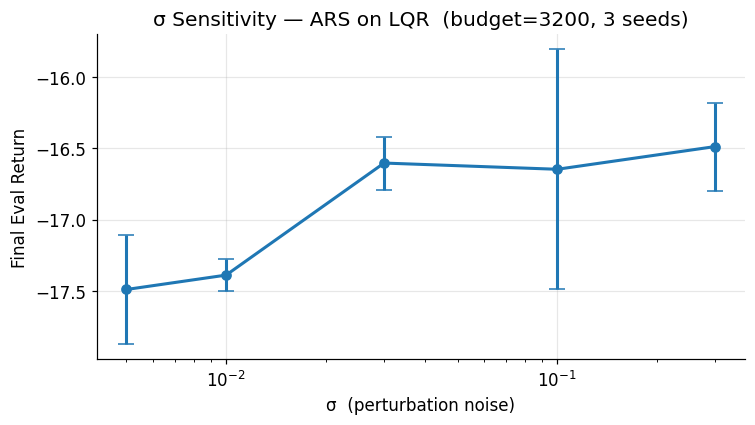

In [16]:
sig_sweep = make_sigma_sensitivity(budget=BUDGET)
sig_sweep.base.seeds = SEEDS
sig_sweep.base.eval_episodes = EVAL_EPISODES
sig_dir = RESULTS_DIR / "sigma_sensitivity"
print("Running σ sensitivity ...")
run_sweep(sig_sweep, sig_dir)

sig_runs   = load_runs_from_dir(sig_dir)
sig_groups = group_runs(sig_runs, lambda r: r["config"]["method"]["sigma"])
sigmas     = sorted(sig_groups)
sig_stats  = [compute_seed_stats(sig_groups[s]) for s in sigmas]
means = [s["mean"][-1] for s in sig_stats]
stds  = [s["std"][-1]  for s in sig_stats]

fig, ax = plt.subplots(figsize=(7, 4))
ax.errorbar(sigmas, means, yerr=stds, marker="o", capsize=5, lw=2, color="tab:blue")
ax.set_xscale("log")
ax.set_xlabel("σ  (perturbation noise)")
ax.set_ylabel("Final Eval Return")
ax.set_title(f"σ Sensitivity — ARS on LQR  (budget={BUDGET}, {len(SEEDS)} seeds)")
plt.tight_layout()
plt.show()

Running α sensitivity ...


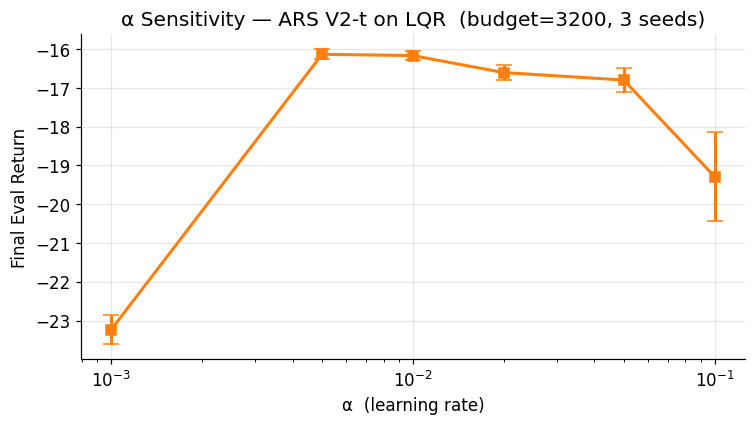

In [17]:
alp_sweep = make_alpha_sensitivity(budget=BUDGET)
alp_sweep.base.seeds = SEEDS
alp_sweep.base.eval_episodes = EVAL_EPISODES
alp_dir = RESULTS_DIR / "alpha_sensitivity"
print("Running α sensitivity ...")
run_sweep(alp_sweep, alp_dir)

alp_runs   = load_runs_from_dir(alp_dir)
alp_groups = group_runs(alp_runs, lambda r: r["config"]["method"]["lr"])
alphas     = sorted(alp_groups)
alp_stats  = [compute_seed_stats(alp_groups[a]) for a in alphas]
means = [s["mean"][-1] for s in alp_stats]
stds  = [s["std"][-1]  for s in alp_stats]

fig, ax = plt.subplots(figsize=(7, 4))
ax.errorbar(alphas, means, yerr=stds, marker="s", capsize=5, lw=2, color="tab:orange")
ax.set_xscale("log")
ax.set_xlabel("α  (learning rate)")
ax.set_ylabel("Final Eval Return")
ax.set_title(f"α Sensitivity — ARS V2-t on LQR  (budget={BUDGET}, {len(SEEDS)} seeds)")
plt.tight_layout()
plt.show()

Running N sensitivity ...


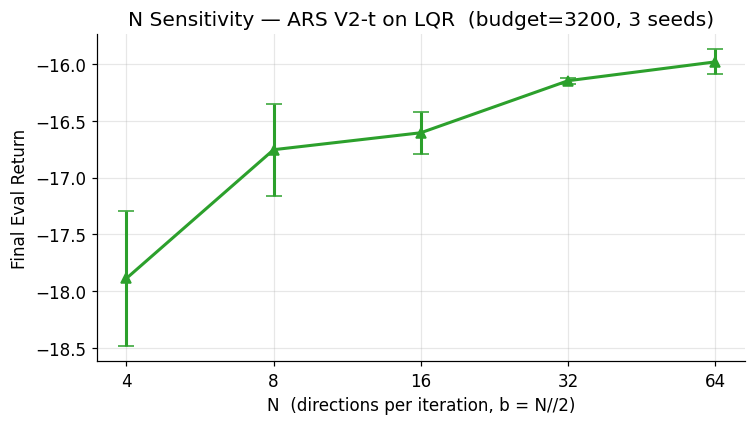

In [18]:
N_sweep = make_N_sensitivity(budget=BUDGET)
N_sweep.base.seeds = SEEDS
N_sweep.base.eval_episodes = EVAL_EPISODES
N_dir = RESULTS_DIR / "N_sensitivity"
print("Running N sensitivity ...")
run_sweep(N_sweep, N_dir)

N_runs   = load_runs_from_dir(N_dir)
N_groups = group_runs(N_runs, lambda r: r["config"]["method"]["N"])
Ns       = sorted(N_groups)
N_stats  = [compute_seed_stats(N_groups[n]) for n in Ns]
means = [s["mean"][-1] for s in N_stats]
stds  = [s["std"][-1]  for s in N_stats]

fig, ax = plt.subplots(figsize=(7, 4))
ax.errorbar(Ns, means, yerr=stds, marker="^", capsize=5, lw=2, color="tab:green")
ax.set_xscale("log", base=2)
ax.set_xticks(Ns)
ax.set_xticklabels([str(n) for n in Ns])
ax.set_xlabel("N  (directions per iteration, b = N//2)")
ax.set_ylabel("Final Eval Return")
ax.set_title(f"N Sensitivity — ARS V2-t on LQR  (budget={BUDGET}, {len(SEEDS)} seeds)")
plt.tight_layout()
plt.show()

---
## Section 4 — Two-Phase Evaluation Protocol
### *Paper §5 + Figure 1*

**Paper protocol:**
1. **Phase 1** — For each (task, variant), grid-search (α, N, σ) over 3 seeds *sampled from [0, 1000)*; select config by min mean episodes-to-threshold. Seeds are sampled from the pool, not fixed to [0,1,2].
2. **Phase 2** — Re-run winning config over 100 seeds sampled from [0, 10000); produce Figure 1-style percentile-band plots.

**This notebook** runs the protocol on:
- **MuJoCo** tasks (paper-faithful) if `mujoco` is installed
- **LQR + Pendulum** as fallback (clearly labeled as non-paper tasks)

Grid deviations in `QUICK_MODE`: 2×2×2=8 configs vs. paper's 3×3×3=27.

In [ ]:
# --- SPECIAL CONFIG OVERRIDE CELL TO REDUCE RUNTIME ---

# Reflects:
# #1 reduce eval seeds
# #2 protocol variants -> V2-t only
# #3 grid size 27 -> 8

# Put this cell BEFORE Phase 1 / Phase 2 cells and run it each session.

# 1) eval100 seeds (pick 20 if you can; 10 if very time-constrained)
EVAL_SEEDS_COUNT = 20   # change to 10 if needed

# 2) protocol variant(s)
PROTOCOL_VARIANTS = ["V2-t"]

# 3) coarse grid (8 configs total = 2x2x2)
GRID_ALPHAS   = [0.01, 0.05]
GRID_N_VALUES = [8, 16]
GRID_SIGMAS   = [0.01, 0.03]

# keep tasks as-is unless you intentionally want to reduce them
# (optional example to force non-MuJoCo fallback):
# PROTOCOL_TASKS = ["lqr", "pendulum"]
# PROTOCOL_NOTE  = "Manual override: non-MuJoCo protocol tasks"

print("Custom protocol overrides applied:")
print(f"  PROTOCOL_TASKS    : {PROTOCOL_TASKS}")
print(f"  PROTOCOL_VARIANTS : {PROTOCOL_VARIANTS}")
print(f"  GRID_ALPHAS       : {GRID_ALPHAS}")
print(f"  GRID_N_VALUES     : {GRID_N_VALUES}")
print(f"  GRID_SIGMAS       : {GRID_SIGMAS}")
print(f"  EVAL_SEEDS_COUNT  : {EVAL_SEEDS_COUNT}")
print(f"  Grid configs/task : {len(GRID_ALPHAS)*len(GRID_N_VALUES)*len(GRID_SIGMAS)}")

Custom protocol overrides applied:
  PROTOCOL_TASKS    : ['lqr', 'pendulum']
  PROTOCOL_VARIANTS : ['V2-t']
  GRID_ALPHAS       : [0.01, 0.05]
  GRID_N_VALUES     : [8, 16]
  GRID_SIGMAS       : [0.01, 0.03]
  EVAL_SEEDS_COUNT  : 20
  Grid configs/task : 8


In [29]:
protocol_dir = RESULTS_DIR / "protocol"
n_grid = len(GRID_ALPHAS) * len(GRID_N_VALUES) * len(GRID_SIGMAS)

print("Phase 1 — Hyperparameter Grid Search")
print(f"  Tasks    : {PROTOCOL_TASKS}")
print(f"  Variants : {PROTOCOL_VARIANTS}")
print(f"  Note     : {PROTOCOL_NOTE}")
print(f"  Grid     : α={GRID_ALPHAS}, N={GRID_N_VALUES}, σ={GRID_SIGMAS}")
print(f"  → {n_grid} configs × 3 seeds (sampled from [0,1000)) = {n_grid*3} runs per (task, variant)")
total_runs = n_grid * 3 * len(PROTOCOL_TASKS) * len(PROTOCOL_VARIANTS)
print(f"  Total    : {total_runs} runs\n")

# Note: seeds=None → _sample_fixed_seeds(n=3, pool_size=1000, rng_seed=0)
# This matches the paper's protocol of sampling 3 fixed seeds from [0, 1000).
# Do NOT pass seeds=[0,1,2] here — that bypasses the paper's seed procedure.
best_configs = run_grid_phase(
    tasks=PROTOCOL_TASKS,
    variants=PROTOCOL_VARIANTS,
    results_dir=protocol_dir,
    budget=BUDGET,
    seeds=None,           # paper-style: sampled from [0,1000)
    alphas=GRID_ALPHAS,
    N_values=GRID_N_VALUES,
    sigmas=GRID_SIGMAS,
)

Phase 1 — Hyperparameter Grid Search
  Tasks    : ['lqr', 'pendulum']
  Variants : ['V2-t']
  Note     : FALLBACK: LQR + Pendulum (MuJoCo not installed).
These are NOT the paper's evaluation tasks.
Install mujoco for paper-faithful results.
  Grid     : α=[0.01, 0.05], N=[8, 16], σ=[0.01, 0.03]
  → 8 configs × 3 seeds (sampled from [0,1000)) = 24 runs per (task, variant)
  Total    : 48 runs


=== Grid search: task=lqr, variant=V2-t ===
  alpha=0.01_N=8_sigma=0.01 seed=636: episodes_to_threshold=160
  alpha=0.01_N=8_sigma=0.01 seed=511: episodes_to_threshold=160
  alpha=0.01_N=8_sigma=0.01 seed=848: episodes_to_threshold=160
  → mean episodes-to-threshold: 160.0
  alpha=0.01_N=8_sigma=0.03 seed=636: episodes_to_threshold=160
  alpha=0.01_N=8_sigma=0.03 seed=511: episodes_to_threshold=160
  alpha=0.01_N=8_sigma=0.03 seed=848: episodes_to_threshold=160
  → mean episodes-to-threshold: 160.0
  alpha=0.01_N=16_sigma=0.01 seed=636: episodes_to_threshold=320
  alpha=0.01_N=16_sigma=0.01 seed=

In [30]:
print("Best configs from Phase 1 (selected by min mean episodes-to-threshold):\n")
for task, vmap in best_configs.items():
    for variant, info in vmap.items():
        score  = info["mean_episodes_to_threshold"]
        solved = score < BUDGET
        thr    = ALL_THRESHOLDS.get(task, 0.0)
        src    = "paper" if task in PAPER_THRESHOLDS else "heuristic (not paper)"
        print(f"  {task:12s} / {variant}:")
        print(f"    Best key  : {info['key']}")
        print(f"    Score     : {score:.0f} eps-to-threshold  "
              f"({'✓ solved' if solved else '✗ not solved'})")
        print(f"    Threshold : {thr:.0f}  ({src})")
        scores = info.get("all_scores", {})
        if scores:
            top3 = sorted(scores.items(), key=lambda x: x[1])[:3]
            print(f"    Top-3     : " + "  |  ".join(f"{k}: {v:.0f}" for k, v in top3))
        print()

Best configs from Phase 1 (selected by min mean episodes-to-threshold):

  lqr          / V2-t:
    Best key  : alpha=0.01_N=8_sigma=0.01
    Score     : 160 eps-to-threshold  (✓ solved)
    Threshold : -50  (heuristic (not paper))
    Top-3     : alpha=0.01_N=8_sigma=0.01: 160  |  alpha=0.01_N=8_sigma=0.03: 160  |  alpha=0.05_N=8_sigma=0.01: 160

  pendulum     / V2-t:
    Best key  : alpha=0.01_N=8_sigma=0.01
    Score     : 3200 eps-to-threshold  (✗ not solved)
    Threshold : -200  (heuristic (not paper))
    Top-3     : alpha=0.01_N=8_sigma=0.01: 3200  |  alpha=0.01_N=8_sigma=0.03: 3200  |  alpha=0.01_N=16_sigma=0.01: 3200



In [ ]:
best_configs_path = protocol_dir / "best_configs.json"
print(f"Phase 2 — {EVAL_SEEDS_COUNT}-Seed Evaluation  (paper uses 100)")
print(f"  Tasks  : {PROTOCOL_TASKS}")
print(f"  Config : {best_configs_path.name}")
print(f"  Seeds  : {EVAL_SEEDS_COUNT} drawn from [0, 10000)\n")

eval_paths = run_eval100_phase(
    best_configs_path=best_configs_path,
    results_dir=protocol_dir,
    budget=BUDGET,
    n_seeds=EVAL_SEEDS_COUNT,
    seed_pool_size=10000,
    seed_rng_seed=42,
)
print(f"\nPhase 2 complete — {len(eval_paths)} files written.")

Phase 2 — 20-Seed Evaluation  (paper uses 100)
  Tasks  : ['lqr', 'pendulum']
  Config : best_configs.json
  Seeds  : 20 drawn from [0, 10000)


=== Eval100: task=lqr, variant=V2-t (α=0.01, N=8, σ=0.01) ===
  seed 1/20 (id=7725) done → eval100_lqr_V2-t_seed7725_seed7725.json
  seed 11/20 (id=4323) done → eval100_lqr_V2-t_seed4323_seed4323.json

=== Eval100: task=pendulum, variant=V2-t (α=0.01, N=8, σ=0.01) ===
  seed 1/20 (id=7725) done → eval100_pendulum_V2-t_seed7725_seed7725.json
  seed 11/20 (id=4323) done → eval100_pendulum_V2-t_seed4323_seed4323.json

Eval100 complete. Wrote 40 files to results/notebook/protocol/eval100

Phase 2 complete — 40 files written.


Note: using quartile bands (fewer than 30 eval seeds).
      Paper Figure 1 uses 0–10 / 10–20 / 20–100 bands with 100 seeds.


V2-t on LQR  (20 seeds)


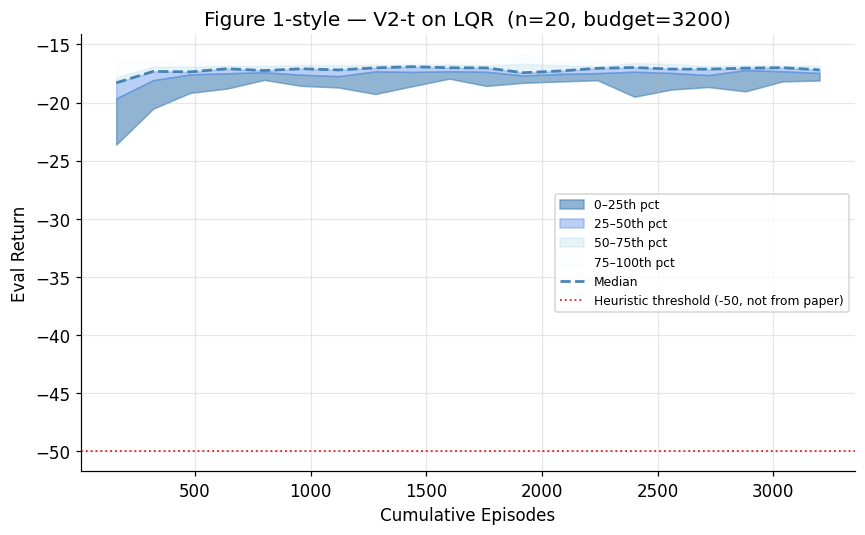

  Final return : -17.2 ± 0.5
  Solved       : 20/20 seeds reached heuristic threshold -50

V2-t on PENDULUM  (20 seeds)


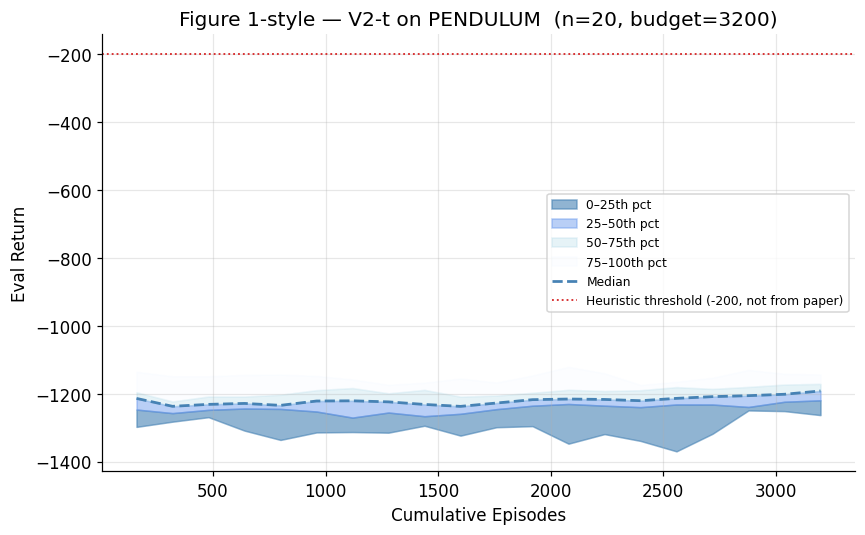

  Final return : -1196.4 ± 34.5
  Solved       : 0/20 seeds reached heuristic threshold -200


In [39]:
# Figure 1-style percentile bands.
# Paper uses 0–10 / 10–20 / 20–100 bands across 100 seeds.
# With few seeds, use quartile bands instead (less misleading).
if EVAL_SEEDS_COUNT >= 30:
    P_BANDS  = [(0, 10), (10, 20), (20, 100)]         # paper Figure 1 style
    PALETTE  = ["steelblue", "cornflowerblue", "lightsteelblue"]
    P_ALPHAS = [0.55, 0.40, 0.25]
else:
    P_BANDS  = [(0, 25), (25, 50), (50, 75), (75, 100)]  # quartile style
    PALETTE  = ["steelblue", "cornflowerblue", "lightblue", "aliceblue"]
    P_ALPHAS = [0.60, 0.45, 0.30, 0.20]
    print(f"Note: using quartile bands (fewer than 30 eval seeds).")
    print(f"      Paper Figure 1 uses 0–10 / 10–20 / 20–100 bands with 100 seeds.\n")


def plot_percentile_inline(runs, title, task):
    stats  = compute_percentile_stats(runs, P_BANDS)
    eps    = stats["episodes"]
    median = stats["median"]

    fig, ax = plt.subplots(figsize=(8, 5))
    for band, color, alpha in zip(stats["bands"], PALETTE, P_ALPHAS):
        ax.fill_between(eps, band["lo"], band["hi"],
                        alpha=alpha, color=color,
                        label=f"{band['lo_pct']}–{band['hi_pct']}th pct")
    ax.plot(eps, median, color="steelblue", ls="--", lw=1.8, label="Median")
    thr = ALL_THRESHOLDS.get(task)
    if thr is not None:
        ax.axhline(thr, color="tab:red", ls=":", lw=1.2,
                   label=threshold_label(task))
    ax.set_xlabel("Cumulative Episodes")
    ax.set_ylabel("Eval Return")
    ax.set_title(title)
    ax.legend(fontsize=8)
    plt.tight_layout()
    plt.show()


eval_dir = protocol_dir / "eval100"
any_plotted = False
for task in PROTOCOL_TASKS:
    task_dir = eval_dir / task
    if not task_dir.exists():
        print(f"  {task}: eval100 results not found, skipping.")
        continue
    for vdir in sorted(p for p in task_dir.iterdir() if p.is_dir()):
        vruns = load_runs_from_dir(vdir)
        if not vruns:
            continue
        n = len(vruns)
        any_plotted = True
        print(f"\n{vdir.name} on {task.upper()}  ({n} seeds)")
        plot_percentile_inline(
            vruns,
            title=(f"Figure 1-style — {vdir.name} on {task.upper()}"
                   f"  (n={n}, budget={BUDGET})"),
            task=task,
        )
        stats = compute_seed_stats(vruns)
        final_mean = stats["mean"][-1]
        final_std  = stats["std"][-1]
        thr = ALL_THRESHOLDS.get(task, 0.0)
        reached = sum(1 for r in vruns if episodes_to_threshold(r, thr) is not None)
        src = "paper" if task in PAPER_THRESHOLDS else "heuristic"
        print(f"  Final return : {final_mean:.1f} ± {final_std:.1f}")
        print(f"  Solved       : {reached}/{n} seeds reached {src} threshold {thr:.0f}")

if not any_plotted:
    print("No eval100 results to plot. Run Phase 2 cell above first.")

---
## Section 5 — LQR Dimension Scaling
### *Paper Appendix A.1*

Compare ARS, Vanilla ES, and REINFORCE across LQR state dimensions 4, 16, 64, 256.
The paper shows ARS degrades gracefully; gradient-based methods struggle at high dimension
due to variance in gradient estimates.

LQR scaling: 12 configs × 3 seeds = 36 runs


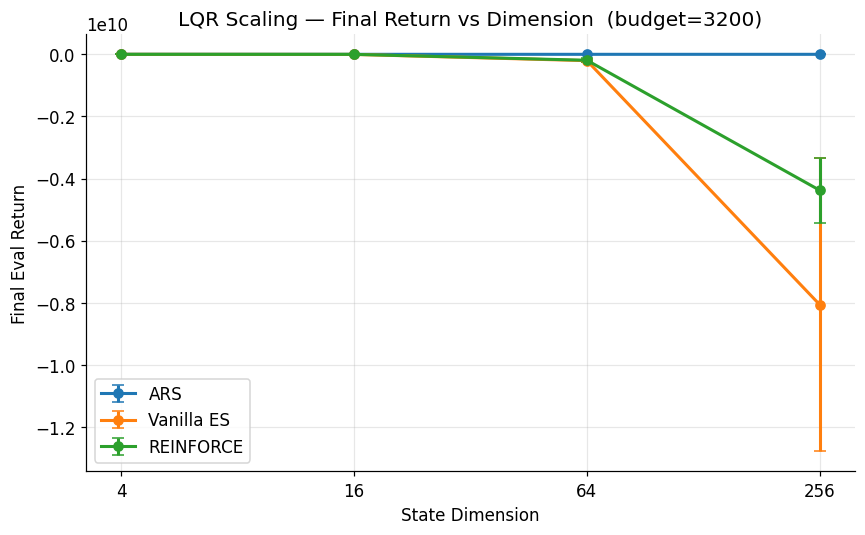

In [40]:
scale_sweep = make_lqr_scaling(budget=BUDGET)
scale_sweep.base.seeds = SEEDS
scale_sweep.base.eval_episodes = EVAL_EPISODES
scale_dir = RESULTS_DIR / "lqr_scaling"

n_total = len(scale_sweep.variants) * len(SEEDS)
print(f"LQR scaling: {len(scale_sweep.variants)} configs × {len(SEEDS)} seeds = {n_total} runs")
run_sweep(scale_sweep, scale_dir)

scale_runs = load_runs_from_dir(scale_dir)
METHOD_LABELS  = {"ars": "ARS", "vanilla_es": "Vanilla ES", "reinforce": "REINFORCE"}
METHOD_COLORS  = {"ARS": "tab:blue", "Vanilla ES": "tab:orange", "REINFORCE": "tab:green"}

scale_groups: dict[str, dict[int, list]] = {}
for r in scale_runs:
    meth = METHOD_LABELS.get(r["config"]["method"]["name"], r["config"]["method"]["name"])
    dim  = r["config"]["env"]["state_dim"]
    scale_groups.setdefault(meth, {}).setdefault(dim, []).append(r)

dims_all = sorted({r["config"]["env"]["state_dim"] for r in scale_runs})
fig, ax = plt.subplots(figsize=(8, 5))
for method, dim_map in scale_groups.items():
    dims  = sorted(dim_map)
    means = [compute_seed_stats(dim_map[d])["mean"][-1] for d in dims]
    stds  = [compute_seed_stats(dim_map[d])["std"][-1]  for d in dims]
    ax.errorbar(dims, means, yerr=stds, label=method, marker="o", capsize=4, lw=2,
                color=METHOD_COLORS.get(method, "gray"))

ax.set_xscale("log", base=2)
ax.set_xticks(dims_all)
ax.set_xticklabels([str(d) for d in dims_all])
ax.set_xlabel("State Dimension")
ax.set_ylabel("Final Eval Return")
ax.set_title(f"LQR Scaling — Final Return vs Dimension  (budget={BUDGET})")
ax.legend()
plt.tight_layout()
plt.show()

---
## Section 6 — MuJoCo Locomotion
### *Paper Table 1 — requires `gymnasium[mujoco]` + `mujoco`*

The paper evaluates ARS V2-t on all 6 MuJoCo tasks. We run all 6 here when MuJoCo is installed.

**Important paper detail**: survival bonus (+1/step) is stripped **during training** for
Hopper, Walker2d, Ant, and Humanoid, then restored for evaluation.
This is handled by `remove_survival_bonus=True` in `EnvConfig`, which creates a separate
standard-reward eval environment inside `run_ars`.

**Budget gap**: the paper trains for up to 1M steps per task. `QUICK_MODE=True` uses a much
shorter budget — results show the learning *direction* but not paper-level final performance.

In [41]:
if not MUJOCO_AVAILABLE:
    print("MuJoCo not available — Section 6 skipped.")
    print("Install: pip install 'gymnasium[mujoco]' mujoco")
else:
    MJ_BUDGET    = 8000   if QUICK_MODE else 200000
    MJ_SEEDS     = [0]    if QUICK_MODE else [0, 1, 2]   # 1 seed in quick mode
    SURVIVAL_TASKS = {"hopper", "walker2d", "ant", "humanoid"}
    MJ_TASKS     = ["swimmer", "hopper", "halfcheetah", "walker2d", "ant", "humanoid"]

    print(f"ARS V2-t on all 6 MuJoCo tasks  (budget={MJ_BUDGET}, seeds={MJ_SEEDS})")
    print(f"Paper thresholds: {PAPER_THRESHOLDS}")
    print(f"Budget gap: paper uses ~1M steps; this demo uses {MJ_BUDGET} episodes.\n")

    mj_dir = RESULTS_DIR / "mujoco"
    mj_results = {}   # task -> list[run dict]

    for task in MJ_TASKS:
        print(f"  Running {task} ...")
        mj_cfg = ExperimentConfig(
            env=EnvConfig(
                name=task,
                remove_survival_bonus=(task in SURVIVAL_TASKS),
            ),
            method=MethodConfig(
                name="ars", N=16, b=8, sigma=0.03, lr=0.02,
                reward_norm=True, use_state_norm=True, variant_label="V2-t",
            ),
            total_episode_budget=MJ_BUDGET,
            max_steps=1000, eval_every_iters=5, eval_episodes=EVAL_EPISODES,
            run_tag=f"mujoco_{task}_v2t",
        )
        task_runs = []
        for seed in MJ_SEEDS:
            path = run_single(mj_cfg, seed=seed, results_dir=mj_dir)
            task_runs.append(load_run(path))
        mj_results[task] = task_runs
        stats = compute_seed_stats(task_runs)
        final = stats["mean"][-1]
        paper_thr = PAPER_THRESHOLDS[task]
        print(f"    final return = {final:.1f}  (paper threshold = {paper_thr:.0f})")

    # ── Grid: one subplot per task ──────────────────────────────────────────
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    for ax, task in zip(axes.ravel(), MJ_TASKS):
        stats = compute_seed_stats(mj_results[task])
        eps  = stats["episodes"]
        mean = np.array(stats["mean"])
        std  = np.array(stats["std"])
        ax.plot(eps, mean, lw=2, color="tab:purple")
        ax.fill_between(eps, mean - std, mean + std, alpha=0.2, color="tab:purple")
        ax.axhline(PAPER_THRESHOLDS[task], color="tab:red", ls="--", lw=1.1)
        ax.set_title(task.capitalize())
        ax.set_xlabel("Episodes")
        ax.set_ylabel("Return")
        ax.text(0.97, 0.05, f"thr={PAPER_THRESHOLDS[task]:.0f}",
                transform=ax.transAxes, ha="right", fontsize=8, color="tab:red")

    fig.suptitle(
        f"ARS V2-t on MuJoCo  (budget={MJ_BUDGET}, seeds={MJ_SEEDS})\n"
        f"Red dashed = paper thresholds (Mania et al. 2018)",
        fontsize=12,
    )
    plt.tight_layout()
    plt.show()

    # ── Table equivalent ─────────────────────────────────────────────────────
    print("\nTable 1-style — MuJoCo results (ARS V2-t, paper thresholds):")
    print(threshold_table(
        {task: mj_results[task] for task in MJ_TASKS},
        thresholds={task: PAPER_THRESHOLDS[task] for task in MJ_TASKS},
    ))
    print(f"\nNote: short budget ({MJ_BUDGET} eps). Paper trains until threshold is reached.")
    print(f"      Set QUICK_MODE=False and MJ_BUDGET=200000+ for meaningful MuJoCo results.")

MuJoCo not available — Section 6 skipped.
Install: pip install 'gymnasium[mujoco]' mujoco


---
## Section 7 — Distributed Implementation Gap

**What the paper does** (§3, implementation details):
- Uses **Ray** for parallel rollout workers
- Workers share a **common noise table** (a large pre-generated array of random numbers); each worker uses a seed/offset into the table, so perturbation directions are reproducible across workers without communication
- `N` rollouts per iteration are collected in parallel across workers
- Total wall-clock time is ~O(1) in workers for fixed episode count

**What this implementation does**:
- Sequential rollouts: each of the 2N perturbations runs one after another
- Wall-clock time scales linearly with N and episode length
- Results are mathematically equivalent but much slower for large N or long horizons

**Impact**: algorithmic correctness is unaffected; only speed differs.
For the short-horizon envs used here (LQR: 200 steps, Pendulum: 200 steps) the
sequential implementation is fast enough. For MuJoCo with 1000-step episodes and
large N, parallelism becomes important to reproduce paper wall-clock times.

---
## Section 8 — Summary: ARS vs. Vanilla ES vs. REINFORCE

Full method comparison on LQR and Pendulum with paper-standard eval (100 rollouts per checkpoint).

Full comparison: 6 configs × 3 seeds = 18 runs


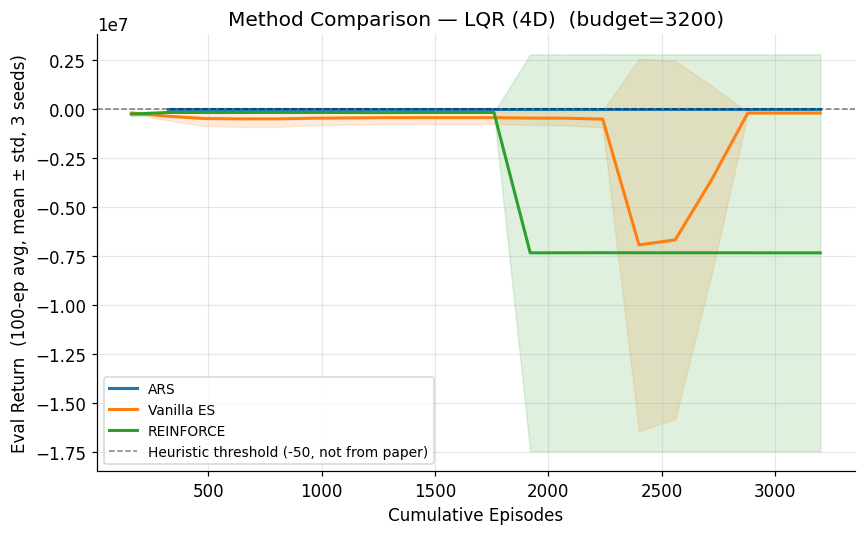


LQR (4D)  (threshold = -50, heuristic — NOT from Mania et al.):
Episodes to threshold (lower = better):
Method            Mean Eps   Median Eps  % Reached
--------------------------------------------------
ARS                    320          320     100.0%
Vanilla ES            3200         3200       0.0%
REINFORCE             3200         3200       0.0%

Max reward across seeds (higher = better):
Method            Max Return   Mean Max    Std Max
--------------------------------------------------
ARS                   -16.02     -16.06       0.04
Vanilla ES        -179104.22 -207097.85   39325.90
REINFORCE         -177997.18 -178195.21     263.29



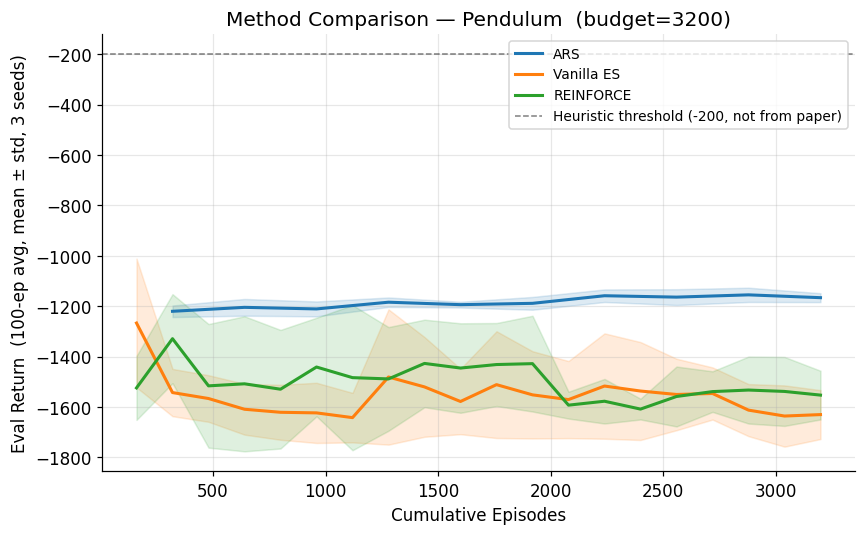


Pendulum  (threshold = -200, heuristic — NOT from Mania et al.):
Episodes to threshold (lower = better):
Method            Mean Eps   Median Eps  % Reached
--------------------------------------------------
ARS                   3200         3200       0.0%
Vanilla ES            3200         3200       0.0%
REINFORCE             3200         3200       0.0%

Max reward across seeds (higher = better):
Method            Max Return   Mean Max    Std Max
--------------------------------------------------
ARS                 -1118.09   -1152.60      27.09
Vanilla ES          -1049.51   -1248.80     238.11
REINFORCE           -1087.33   -1206.02     134.53



In [42]:
fc_sweep = make_full_comparison(budget=BUDGET)
fc_sweep.base.seeds = SEEDS
fc_sweep.base.eval_episodes = EVAL_EPISODES
fc_dir = RESULTS_DIR / "full_comparison"

n_total = len(fc_sweep.variants) * len(SEEDS)
print(f"Full comparison: {len(fc_sweep.variants)} configs × {len(SEEDS)} seeds = {n_total} runs")
run_sweep(fc_sweep, fc_dir)

fc_runs = load_runs_from_dir(fc_dir)
fc_groups: dict[str, dict[str, list]] = {}
for r in fc_runs:
    env  = r["config"]["env"]["name"]
    meth = METHOD_LABELS.get(r["config"]["method"]["name"], r["config"]["method"]["name"])
    fc_groups.setdefault(env, {}).setdefault(meth, []).append(r)

for env_name, env_display in [("lqr", "LQR (4D)"), ("pendulum", "Pendulum")]:
    method_runs = fc_groups.get(env_name, {})
    if not method_runs:
        continue

    fig, ax = plt.subplots(figsize=(8, 5))
    for method, mruns in method_runs.items():
        stats = compute_seed_stats(mruns)
        eps  = stats["episodes"]
        mean = np.array(stats["mean"])
        std  = np.array(stats["std"])
        color = METHOD_COLORS.get(method, "gray")
        ax.plot(eps, mean, label=method, color=color, lw=2)
        ax.fill_between(eps, mean - std, mean + std, alpha=0.15, color=color)

    thr = PROJECT_THRESHOLDS.get(env_name)
    if thr is not None:
        ax.axhline(thr, color="k", ls="--", lw=1, alpha=0.5,
                   label=threshold_label(env_name))
    ax.set_xlabel("Cumulative Episodes")
    ax.set_ylabel(f"Eval Return  ({EVAL_EPISODES}-ep avg, mean ± std, {len(SEEDS)} seeds)")
    ax.set_title(f"Method Comparison — {env_display}  (budget={BUDGET})")
    ax.legend(fontsize=9)
    plt.tight_layout()
    plt.show()

    thr_val = PROJECT_THRESHOLDS.get(env_name, 0.0)
    print(f"\n{env_display}  (threshold = {thr_val:.0f}, heuristic — NOT from Mania et al.):")
    print("Episodes to threshold (lower = better):")
    print(threshold_table(method_runs, thresholds=thr_val))
    print("\nMax reward across seeds (higher = better):")
    print(max_reward_table(method_runs))
    print()

In [43]:
print("=" * 65)
print("  EXPERIMENT SUMMARY")
print("=" * 65)
print(f"\n  Mode             : {'QUICK' if QUICK_MODE else 'FULL PAPER-SCALE'}")
print(f"  Budget/run       : {BUDGET} episodes")
print(f"  Eval episodes    : {EVAL_EPISODES} rollouts/checkpoint (paper standard)")
print(f"  Seeds (sweeps)   : {SEEDS}")
print(f"  Seeds (Phase 2)  : {EVAL_SEEDS_COUNT}  (paper: 100)")
print(f"  Protocol tasks   : {PROTOCOL_TASKS}")
print(f"  Protocol note    : {PROTOCOL_NOTE}")
print()
print("  Sections run:")
print("    § 1  Sanity check           ARS V2-t on LQR  (eval_episodes=20, speed only)")
print("    § 2  Variant comparison     BRS/V1/V1-t/V2/V2-t × LQR + Pendulum")
print("    § 3  σ / α / N sensitivity  5+6+5 configs × 3 seeds on LQR")
print(f"    § 4  Two-phase protocol     {PROTOCOL_NOTE[:40]}...")
print("    § 5  LQR scaling            4 dims × 3 methods × 3 seeds")
mj_stat = "All 6 tasks" if MUJOCO_AVAILABLE else "SKIPPED (mujoco not installed)"
print(f"    § 6  MuJoCo locomotion      {mj_stat}")
print("    § 7  Distributed gap        Documentation cell")
print("    § 8  Full comparison        ARS / Vanilla ES / REINFORCE × LQR + Pendulum")
print()
print("  Implementation correctness vs. paper:")
print("    ✓ V1/V2 use b=N (all directions); V1-t/V2-t use b=N//2 (top-b)")
print("    ✓ reward_norm divides by σ_R only when enabled (V1/V1-t/V2/V2-t)")
print("    ✓ State norm: Welford RunningNorm; low-var dims → 0 (paper §4 fn.1)")
print("    ✓ Eval: FrozenNorm, no update; paper: 100 rollouts per checkpoint")
print("    ✓ Train/eval envs separated for survival-bonus tasks")
print("    ✓ Phase 1 seeds sampled from [0,1000); Phase 2 from [0,10000)")
print("    ✗ Sequential rollouts (paper uses Ray + shared noise table)")
print("    ✗ MuJoCo budget << paper budget when QUICK_MODE=True")
print()
print("  To fully replicate paper results:")
print("    1. Set QUICK_MODE = False")
print("    2. Install mujoco: pip install 'gymnasium[mujoco]' mujoco")
print("    3. Run sweep_protocol.py --phase grid on all 6 MuJoCo tasks")
print("    4. Run sweep_protocol.py --phase eval100 with 100 seeds")
print(f"\n  Results directory: {RESULTS_DIR.resolve()}")

  EXPERIMENT SUMMARY

  Mode             : FULL PAPER-SCALE
  Budget/run       : 3200 episodes
  Eval episodes    : 100 rollouts/checkpoint (paper standard)
  Seeds (sweeps)   : [0, 1, 2]
  Seeds (Phase 2)  : 20  (paper: 100)
  Protocol tasks   : ['lqr', 'pendulum']
  Protocol note    : FALLBACK: LQR + Pendulum (MuJoCo not installed).
These are NOT the paper's evaluation tasks.
Install mujoco for paper-faithful results.

  Sections run:
    § 1  Sanity check           ARS V2-t on LQR  (eval_episodes=20, speed only)
    § 2  Variant comparison     BRS/V1/V1-t/V2/V2-t × LQR + Pendulum
    § 3  σ / α / N sensitivity  5+6+5 configs × 3 seeds on LQR
    § 4  Two-phase protocol     FALLBACK: LQR + Pendulum (MuJoCo not ins...
    § 5  LQR scaling            4 dims × 3 methods × 3 seeds
    § 6  MuJoCo locomotion      SKIPPED (mujoco not installed)
    § 7  Distributed gap        Documentation cell
    § 8  Full comparison        ARS / Vanilla ES / REINFORCE × LQR + Pendulum

  Implementation 